In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Import and explore dataset

In [136]:
project_dir = 'C:/Users/huang/Downloads/ClaimPredictionChallenge/'
train_set = pd.read_csv(project_dir + 'train_set/train_set.csv')

In [137]:
train_set.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,1,1,3,2005,2005,K,K.78,K.78.2,D,C,...,1.008912,0.261040,0.907793,-0.077998,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2,2,2,2005,2003,Q,Q.22,Q.22.3,B,C,...,1.240851,0.432987,-0.726459,0.204785,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,3,3,1,2005,1998,AR,AR.41,AR.41.1,B,?,...,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,4,3,1,2006,1998,AR,AR.41,AR.41.1,B,?,...,-0.971487,-1.405797,-0.837048,-1.176858,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,5,3,2,2005,2001,D,D.20,D.20.0,J,C,...,0.812656,2.112691,1.534462,2.347260,F,-0.23153,-0.266117,-0.272337,-0.251419,0.0


In [138]:
print(f'There are {train_set.shape[0]:,} rows and {train_set.shape[1]} columns in the trainset.')

There are 13,184,290 rows and 35 columns in the trainset.


In [139]:
# Replace all the "?" by NA
train_set.replace('?', pd.NA, inplace=True)

# Drop column 'Row_ID'
train_set.drop(columns=['Row_ID'], axis = 1, inplace=True)

In [140]:
# Check the data type, number of unique values and number of missing values in each collumn

num_of_missing_values = train_set.isnull().sum()
percentage_missing = ((num_of_missing_values / train_set.shape[0]) * 100).apply('{:.2f}%'.format)

data = {
    'Data Type' : train_set.dtypes,
    'Number of Unique Values' : train_set.nunique(),
    'Number of Missing Values' : num_of_missing_values,
    'Percentage of Missing Values' : percentage_missing
} 

pd.DataFrame(data)

,Data Type,Number of Unique Values,Number of Missing Values,Percentage of Missing Values
Household_ID,int64,4309042,0,0.00%
Vehicle,int64,28,0,0.00%
Calendar_Year,int64,3,0,0.00%
Model_Year,int64,29,0,0.00%
Blind_Make,object,74,8431,0.06%
Blind_Model,object,1302,8431,0.06%
Blind_Submodel,object,2739,8431,0.06%
Cat1,object,10,25981,0.20%
Cat2,object,3,4874164,36.97%
Cat3,object,6,3999,0.03%


In [141]:
print('There are so many missing values in some of the columns, \nluckly, we have a large amount of record here.')

There are so many missing values in some of the columns, 
luckly, we have a large amount of record here.


In [142]:
# Check how many rows have claims
train_set[train_set['Claim_Amount'] != 0].shape[0]


95605

In [143]:
print('The dataset is highly imbalanced.')

The dataset is highly imbalanced.


# Clean the trainset

In [145]:
print('Since "the same Vehicle number may not apply to the same vehicle from year to year", \nI will not include this column, and Year_Used may be more useful than Calendar_Year \nand Model_Year.')

Since "the same Vehicle number may not apply to the same vehicle from year to year", 
I will not include this column, and Year_Used may be more useful than Calendar_Year 
and Model_Year.


In [146]:
# Get the column list of the trainset
column_list = train_set.columns.to_list()

# Calculate the year used for each car
train_set['Year_Used'] = train_set['Calendar_Year'] - train_set['Model_Year'] + 1

# Remove 'Household_ID', 'Vehicle', 'Calendar_Year', 'Model_Year' from column_list
for column in ['Household_ID', 'Vehicle', 'Calendar_Year', 'Model_Year']:
    column_list.remove(column)

# Add 'Year_Used' to column_list in the first place
column_list.insert(0, 'Year_Used')

# Reorder the trainset
train_set = train_set[column_list]

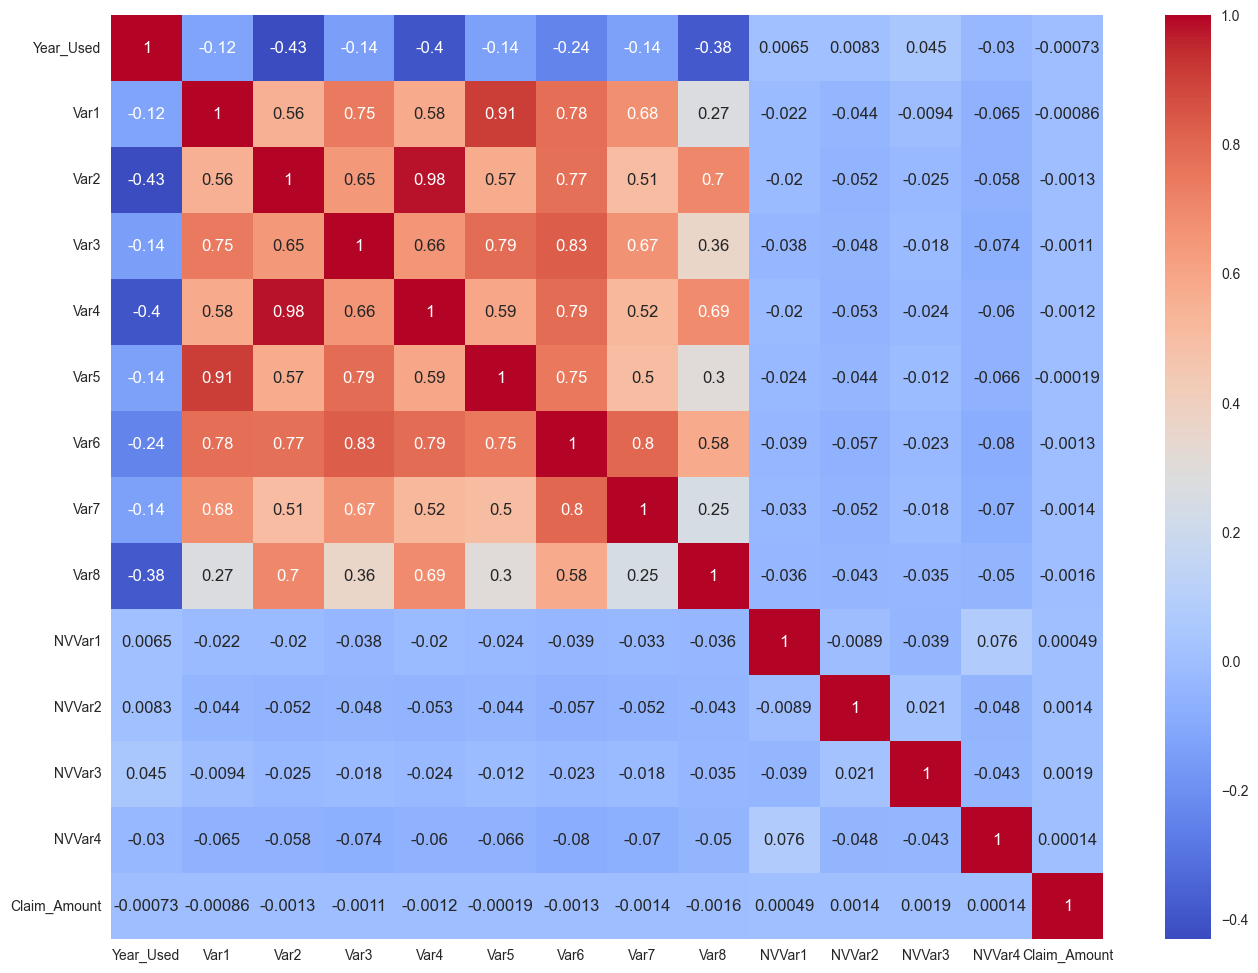

In [147]:
# Draw correlation matrix for the numerical features

# Compute the correlation matrix
numeric_columns = train_set.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

# Create the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [134]:
print('Some of the numeric columns are highly correlated, we need to deal with this.')

Some of the numeric columns are highly correlated, we need to deal with this.


In [155]:
# Check the number of records that do not have null values
df = train_set.dropna()
print(f'The number of records that do not have null values is {df.shape[0]:,}, which is {(df.shape[0]/train_set.shape[0])*100:.2f}% of the total records.')

# Check the number of records that do not have a claim amount
have_no_claim = df[df['Claim_Amount'] == 0].shape[0]
print(f'\nThe number of records that do not have a claim amount is {have_no_claim:,}, which is {(have_no_claim/df.shape[0])*100:.2f}%.')

# Check the number of records that have a claim amount
have_claim = df[df['Claim_Amount'] != 0].shape[0]
print(f'\nThe number of records that have a claim amount is {have_claim:,}, which is {(have_claim/df.shape[0])*100:.2f}%.')

The number of records that do not have null values is 3,726,301, which is 28.26% of the total records.

The number of records that do not have a claim amount is 3,698,222, which is 99.25%.

The number of records that have a claim amount is 28,079, which is 0.75%.


In [158]:
print('Not that much but we can still have a try.')
print('\nBelow, we use the records that have no missing values to make prediction.')

Not that much but we can still have a try.

Below, we use the records that have no missing values to make prediction.


In [160]:
# Principal Component Analysis

# Identify numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.drop(['Year_Used', 'Claim_Amount'])

# Create a transformer for numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns)
    ])

# Create a PCA pipeline
pca_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('pca', PCA(n_components=0.95))])

# Fit and transform the pipeline
pca_data = pca_pipeline.fit_transform(df[numeric_columns])

In [173]:
# Use pca data to replace the numeric columns in df

# Convert pca_data into a DataFrame
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i}' for i in range(pca_data.shape[1])])

# Get the remained columns
remained_columns = df.columns.drop(numeric_columns)

# Reset the index of pca_df to ensure alignment
pca_df.reset_index(drop=True, inplace=True)

# Create the DataFrame for non-numeric and additional columns
remained_columns_df = df[remained_columns].reset_index(drop=True)

# Concatenate the PCA DataFrame with the selected non-numeric DataFrame
df_pca = pd.concat([pca_df, remained_columns_df], axis=1)

In [174]:
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,Year_Used,Blind_Make,Blind_Model,...,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,OrdCat,NVCat,Claim_Amount
0,3.328573,-0.556732,-0.094189,-0.104542,-0.206078,-0.096739,-1.741903,3,Q,Q.22,...,E,C,A,B,A,B,D,5,O,0.0
1,3.428592,-1.976805,-0.152645,-0.070994,-0.164965,-0.109451,0.439556,6,AJ,AJ.129,...,E,A,A,B,A,E,C,4,M,0.0
2,1.623180,-0.068528,-0.017078,-0.187601,-0.295348,-0.158505,-0.838936,5,AQ,AQ.17,...,D,C,B,A,A,C,B,4,M,0.0
3,1.623180,-0.068528,-0.017078,-0.187601,-0.295348,-0.158505,-0.838936,4,AQ,AQ.17,...,D,C,B,A,B,B,C,4,M,0.0
4,1.665078,0.010751,-0.011772,-0.189338,-0.300043,-0.154577,-0.810512,2,AQ,AQ.17,...,D,C,B,A,B,A,C,4,O,0.0


In [178]:
df_pca['Claimed'] = df_pca['Claim_Amount'].apply(lambda x: 1 if x != 0 else 0)

In [183]:
df_pca.to_csv(project_dir+'df_pca.csv', index=False)

In [2]:
project_dir = 'C:/Users/huang/Downloads/ClaimPredictionChallenge/'
df_pca = pd.read_csv(project_dir+'df_pca.csv')

# Model Building

In [13]:
X = df_pca[df_pca.columns.drop(['Claim_Amount', 'Claimed'])]
y = df_pca['Claim_Amount']

In [14]:
# Trainset and testset spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [16]:
lgbmr_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30]
}

# Initialize the base model
model_lgbmr = LGBMRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbmr = RandomizedSearchCV(
    estimator=model_lgbmr, 
    param_distributions=lgbmr_param_grid, 
    n_iter=100,
    scoring='neg_mean_squared_error', 
    cv=3,
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

random_search_lgbmr.fit(X_train, y_train)

best_model_lgbmr = random_search_lgbmr.best_estimator_

# Make predictions using the best model
y_pred_lgbmr = best_model_lgbmr.predict(X_test)

# Calculate metrics
rmse_lgbmr = np.sqrt(mean_squared_error(y_test, y_pred_lgbmr))
r2_lgbmr = r2_score(y_test, y_pred_lgbmr)

print(f"Root Mean Squared Error: {rmse_lgbmr}")
print(f"R-squared: {r2_lgbmr}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\sklearn.py", line 1049, in fit
    super().fit(
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py", line 255, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\basic.py", line 3200, in __init__
    train_set.construct()
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\basic.py", line 2276, in construct
    self._lazy_init(data=self.data, label=self.label, reference=None,
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\basic.py", line 1861, in _lazy_init
    data, feature_name, categorical_feature, self.pandas_categorical = _data_from_pandas(
                                                                       ^^^^^^^^^^^^^^^^^^
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\basic.py", line 703, in _data_from_pandas
    _check_for_bad_pandas_dtypes(data.dtypes)
  File "C:\Users\huang\AppData\Roaming\Python\Python311\site-packages\lightgbm\basic.py", line 666, in _check_for_bad_pandas_dtypes
    raise ValueError('pandas dtypes must be int, float or bool.\n'
ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Blind_Make: object, Blind_Model: object, Blind_Submodel: object, Cat1: object, Cat2: object, Cat3: object, Cat4: object, Cat5: object, Cat6: object, Cat7: object, Cat8: object, Cat9: object, Cat10: object, Cat11: object, Cat12: object, NVCat: object
